## Trial Recurrent Neural Network

With the change to the data set (i.e. dropping betting data), it seems that we have to go back to basics, because earlier experiments are no longer valid, resulting in a different set of algorithms having stronger performance. The experiments with deep learning in 2019 yielded performance comparable to simpler models, and I decided not to pursue them at the time, because comparable performance isn't worth the extra time for training/param-tuning required. With the current benchmark being a bit lower, however, it's worth seeing if a deep neural net can surpass simpler models.

To avoid spending too much time on this, I'm going to focus on RNNs, because it was the best-performing architecture from earlier experiments and lends itself to the time-based nature of AFL matches.

## Code setup

In [1]:
%load_ext autoreload

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.experimental import enable_halving_search_cv
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from mlxtend.feature_selection import ColumnSelector

from augury.ml_data import MLData
from augury.model_tracking import graph_tf_model_history
from augury.settings import SEED, CV_YEAR_RANGE, CATEGORY_COLS, TEAM_NAMES, ROUND_TYPES, VENUES
from augury.sklearn.models import RNNRegressor
from augury.sklearn.preprocessing import ColumnDropper

np.random.seed(SEED)

/usr/local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [3]:
data = MLData(train_year_range=(max(CV_YEAR_RANGE),))
data.data

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-02-21 06:32:24,968 - kedro.io.data_catalog - INFO - Loading data from `full_data` (JSONDataSet)...


team      oppo_team round_type  \
Adelaide         1991 1           Adelaide       Hawthorn    Regular   
                      2           Adelaide        Carlton    Regular   
                      3           Adelaide         Sydney    Regular   
                      4           Adelaide       Essendon    Regular   
                      5           Adelaide     West Coast    Regular   
...                                    ...            ...        ...   
Western Bulldogs 2021 19  Western Bulldogs       Adelaide    Regular   
                      20  Western Bulldogs      Melbourne    Regular   
                      21  Western Bulldogs       Essendon    Regular   
                      22  Western Bulldogs       Hawthorn    Regular   
                      23  Western Bulldogs  Port Adelaide    Regular   

                                   venue prev_match_oppo_team  \
Adelaide         1991 1    Football Park                    0   
                      2    Football Park             Hawthorn   
                      3           S.C.G.              Carlton   
                      4       Windy Hill               Sydney   
                      5          Subiaco             Essendon   
...                                  ...                  ...   
Western Bulldogs 2021 19  Eureka Stadium           Gold Coast   
                      20          M.C.G.             Adelaide   
                      21       Docklands            Melbourne   
                      22       York Park             Essendon   
                      23       Docklands             Hawthorn   

                         oppo_prev_match_oppo_team                      date  \
Adelaide         1991 1                  Melbourne 1991-03-22 03:56:00+00:00   
                      2                    Fitzroy 1991-03-31 03:56:00+00:00   
                      3                   Hawthorn 1991-04-07 03:05:00+00:00   
                      4            North Melbourne 1991-04-13 03:30:00+00:00   
                      5            North Melbourne 1991-04-21 05:27:00+00:00   
...                                            ...                       ...   
Western Bulldogs 2021 19                West Coast 2021-07-24 02:20:00+00:00   
                      20                Gold Coast 2021-07-31 02:20:00+00:00   
                      21                    Sydney 2021-08-07 02:20:00+00:00   
                      22               Collingwood 2021-08-14 02:11:00+00:00   
                      23                   Carlton 2021-08-21 02:20:00+00:00   

                          team_goals  team_behinds  score  ...  \
Adelaide         1991 1           24            11    155  ...   
                      2           12             9     81  ...   
                      3           19            18    132  ...   
                      4            6            11     47  ...   
                      5            9            11     65  ...   
...                              ...           ...    ...  ...   
Western Bulldogs 2021 19           0             0      0  ...   
                      20           0             0      0  ...   
                      21           0             0      0  ...   
                      22           0             0      0  ...   
                      23           0             0      0  ...   

                          oppo_rolling_prev_match_time_on_ground_skew  \
Adelaide         1991 1                                           0.0   
                      2                                           0.0   
                      3                                           0.0   
                      4                                           0.0   
                      5                                           0.0   
...                                                               ...   
Western Bulldogs 2021 19                                          0.0   
                      20                              

### Create pipelines

## Basic RNN for baseline performance

RNNRegressor mostly uses the defaults for a Keras RNN model with LSTM cells. It has one hidden layer and measures accuracy, but optimises toward MAE, because accuracy doesn't lend itself easily to a loss function for a regressor. I chose 6 steps for the time-series, because that's a quarter of an average season, which seems like a decent starting point.

In [4]:
ELO_MODEL_COLS = [
    "prev_match_oppo_team",
    "oppo_prev_match_oppo_team",
    "prev_match_at_home",
    "oppo_prev_match_at_home",
    "date",
]

N_STEPS = 6

X_train, _ = data.train_data
n_features = X_train.shape[1] - len(ELO_MODEL_COLS)

rnn_pipeline = make_pipeline(
    ColumnDropper(cols_to_drop=ELO_MODEL_COLS),
    ColumnTransformer(
        [
            (
                "ordinalencoder",
                OrdinalEncoder(categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES, VENUES]),
                CATEGORY_COLS,
            )
        ],
        remainder=StandardScaler(),
    ),
    RNNRegressor(
        n_features=n_features,
        n_steps=N_STEPS,
        epochs=100,
        verbose=1
    ),
)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
rnn_pipeline.fit(*data.train_data)
None

Epoch 1/100
767/767 [==============================] - 11s 11ms/step - loss: 30.6706 - regressor_team_match_accuracy: 0.6172 - val_loss: 29.8392 - val_regressor_team_match_accuracy: 0.6508
Epoch 2/100
767/767 [==============================] - 8s 10ms/step - loss: 29.2985 - regressor_team_match_accuracy: 0.6602 - val_loss: 29.5007 - val_regressor_team_match_accuracy: 0.6563
Epoch 3/100
767/767 [==============================] - 8s 10ms/step - loss: 28.7777 - regressor_team_match_accuracy: 0.6790 - val_loss: 29.1111 - val_regressor_team_match_accuracy: 0.6628
Epoch 4/100
767/767 [==============================] - 8s 10ms/step - loss: 28.2329 - regressor_team_match_accuracy: 0.6809 - val_loss: 28.7932 - val_regressor_team_match_accuracy: 0.6779
Epoch 5/100
767/767 [==============================] - 8s 11ms/step - loss: 28.3230 - regressor_team_match_accuracy: 0.6827 - val_loss: 28.6830 - val_regressor_team_match_accuracy: 0.6746
Epoch 6/100
767/767 [==============================] - 7s 1

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


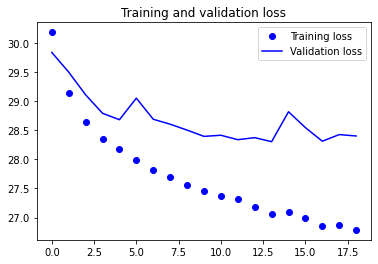

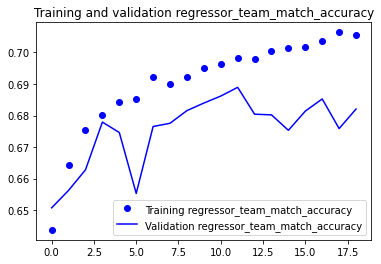

In [6]:
graph_tf_model_history(rnn_pipeline.steps[-1][1].history, metrics=['regressor_team_match_accuracy'])

Performance is in the ballpark with other top models, though about 2% lower accuracy (this is from being trained on a full training data set and validated on 2019 data, however, rather than using a multi-fold CV from recent years, so it's not apples-to-apples).